In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

import set_config

In [15]:
dir_local = set_config.ConfigSectionMap("SectionOne")['local']
dir_sanofi_share = set_config.ConfigSectionMap("SectionOne")['sanofi']

In [16]:
def get_col_widths(dataframe):
    # First we find the maximum length of the index column   
    idx_max = max([len(str(s)) for s in dataframe.index.values] + [len(str(dataframe.index.name))])
    # Then, we concatenate this to the max of the lengths of column name and its values for each column, left to right
    return [idx_max] + [max([len(str(s)) for s in dataframe[col].values] + [len(col)]) for col in dataframe.columns]


In [17]:
folder='IP21'
filename = 'alarms.csv'
path = os.path.join(dir_local, folder, filename)
# parse_dates and index datafram
df = pd.read_csv(path, encoding='UTF-8', parse_dates=True, index_col='Start')
df.sort_index(inplace=True)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
# df = pd.read_csv(r'C:\Users\Raza-PC\Documents\McLaren\Sanofi\Sanofi\alarms.csv')

C:\Users\mark_\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [20]:
df.head()

,Message Text (English),Message Text,Duration,Filename,Machine,Significant
Start,,,,,,
2020-12-28 10:25:23,The maintenance interval has expired: lubricat...,Das Wartungsintervall ist abgelaufen: Schmieru...,NaN,AL6Audit Trail 150001 2021-02-04 K747B14.csv,AL6_Etikettierer,NaN
2020-12-28 10:25:23,The maintenance interval has expired: lubricat...,Das Wartungsintervall ist abgelaufen: Schmieru...,NaN,AL6Audit Trail 150001 2021-02-04 K747B14.csv,AL6_Etikettierer,NaN
2020-12-28 10:25:23,The maintenance interval has expired: lubricat...,Das Wartungsintervall ist abgelaufen: Schmieru...,NaN,AL6Audit Trail 150001 2021-02-04 K747B14.csv,AL6_Etikettierer,NaN
2020-12-28 10:25:23,The maintenance interval has expired: lubricat...,Das Wartungsintervall ist abgelaufen: Schmieru...,NaN,AL6Audit Trail 143822 2021-02-14 K747B14.csv,AL6_Etikettierer,NaN
2020-12-28 10:25:23,The maintenance interval has expired: lubricat...,Das Wartungsintervall ist abgelaufen: Schmieru...,NaN,AL6Audit Trail 144135 2021-01-13 K747B14.csv,AL6_Etikettierer,NaN


In [21]:
#Define start and end date for specified time period, number of days is calculated.

start_date = '2021-09-01'
end_date = '2021-11-01'

days = datetime.strptime(end_date, '%Y-%m-%d')-datetime.strptime(start_date, '%Y-%m-%d')
ndays=days.days

# df_dates=df[(df['Start'] >= start_date) & (df['Start'] <= end_date) ]
df_dates=df[(df.index >= start_date) & (df.index <= end_date) ]
# df_dates = df.loc[start_date:end_date]


# df_dates=df_dates[df_dates['Filename'].str.contains(machine)]

In [22]:
folder='IP21'
filename='Alarms_Reader_Messages.xlsx'
path = os.path.join(dir_local, folder, filename)
writer = pd.ExcelWriter(path, engine='xlsxwriter')
for temp_machine in df_dates.Machine.unique():
    temp_df = df_dates[df_dates.Machine.str.contains(temp_machine)]
    grouped = temp_df[['Machine', 'Message Text (English)','Duration']].groupby(['Message Text (English)']).agg({'Duration':'sum', 'Message Text (English)': 'count'})
    # convert Duration secs to mins
    grouped['Duration'] = round (grouped['Duration'] / 60, 0)
    grouped.rename(columns={'Duration':'Duration (mins)'}, inplace=True)
    grouped.rename(columns={'Message Text (English)':'count'}, inplace=True)
    # grouped.nlargest(25, 'Duration')
    grouped.sort_values(by=(['Duration (mins)', 'count']), ascending=False, inplace=True)
    grouped = grouped.nlargest(25, 'Duration (mins)')
    grouped.to_excel(writer, sheet_name=temp_machine)
    # call function get_col_widths to auto size the excel columns
    workbook = writer.book
    worksheet = writer.sheets[temp_machine]
    for x, width in enumerate(get_col_widths(grouped)):
        #set each column width to be 1*25 that of the max string so that it fits nicely
        worksheet.set_column(x, x, width * 1.3)    



df_dates.sort_values(by=['Duration'], ascending=False).reset_index(inplace=True)
df_dates.to_excel(writer, sheet_name='all_messages')
workbook = writer.book
worksheet = writer.sheets['all_messages']
for x, width in enumerate(get_col_widths(grouped)):
    #set each column width to be 1*25 that of the max string so that it fits nicely
    worksheet.set_column(x, x, width * 1.3)    
writer.save()

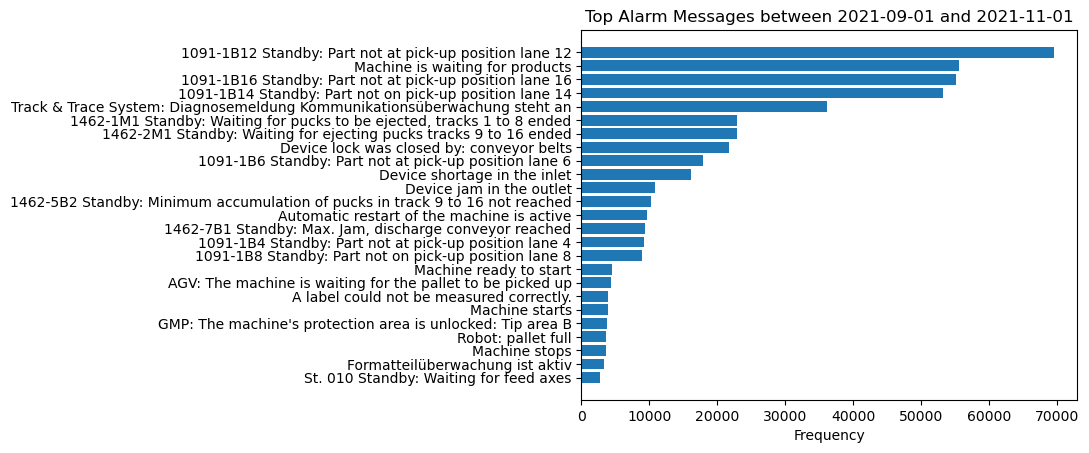

In [23]:
s=df_dates['Message Text (English)'].value_counts()
#Show top 25 alert messages
top=s.nlargest(25)
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
names = (top.index)
y_pos = np.arange(len(names))
performance= top.values

ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Frequency')
ax.set_title('Top Alarm Messages between {} and {}'.format(start_date, end_date))

plt.show()

In [24]:
#Group data by alert message and calculate mean duration and frequency. Convert duration to minutes.
m=df_dates.groupby('Message Text (English)').agg(['mean', 'count'])
mc = m['Duration']['mean'] * m['Duration']['count'] / (60*ndays)

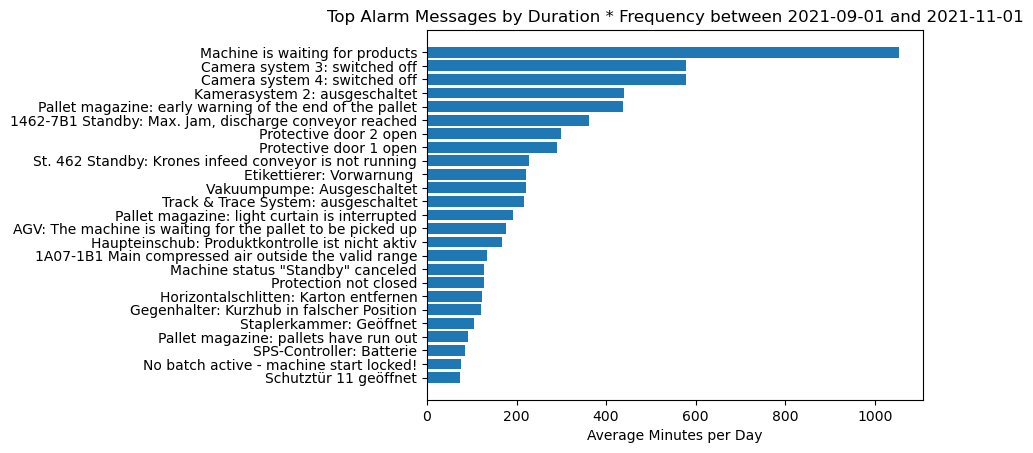

In [25]:
#Plot top 25 most significant error messages.
top=mc.nlargest(25)
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
names = (top.index)
y_pos = np.arange(len(names))
performance= top.values

ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Average Minutes per Day')
ax.set_title('Top Alarm Messages by Duration * Frequency between {} and {}'.format(start_date, end_date))

plt.show()

In [26]:
df_dates.sort_values(by=['Duration'], ascending=False).reset_index(inplace=True)

In [27]:
m

Duration      
                                                           mean count
Message Text (English)                                               
 = A + 52-AP-U1 # AS-i error                          39.285714     7
 = D + 52-AP-U1 # AS-i error                         986.000000     3
 =A+52-AP# Bremsrelais nicht abgeschaltet             65.000000     2
1001-1M1 Camshaft position not valid. Please re...   128.000000     1
1002-1M1 Camshaft position not valid. Please re...   128.000000     1
...                                                         ...   ...
[Q] VT_608 # Sensor error folding box adhesive ...   101.219512    82
[Q] VT_608 # Sensor error folding box height OK...    67.000000     6
[Q] VT_608 # Sensor error folding box length OK...   228.888889    18
[Q] VT_608 # Sensor error folding box length OK...   477.000000     8
xxx - parts of the order size reached               1280.133333    30

[989 rows x 2 columns]

Text(0.5, 1.0, 'Count of roll alerts for Etikettierer')

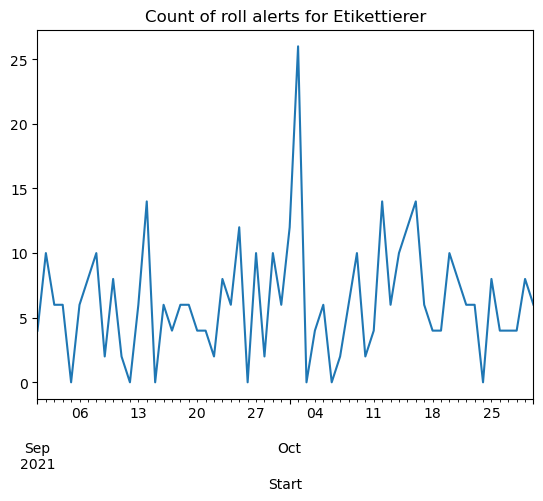

In [30]:
df_label = df_dates[df_dates['Message Text (English)'].str.contains('The label roll is empty')]
df_label.groupby(pd.Grouper(freq='D'))['Machine'].count().plot()
plt.title('Count of roll alerts for Etikettierer')

In [31]:
df_label

,Message Text (English),Message Text,Duration,Filename,Machine,Significant
Start,,,,,,
2021-09-01 04:10:26,The label roll is empty,Die Etikettenrolle ist leer,NaN,AL6Audit Trail 060001 2021-09-01 K747B14.csv,AL6_Etikettierer,Yes
2021-09-01 04:10:58,The label roll is empty,Die Etikettenrolle ist leer,NaN,AL6Audit Trail 060001 2021-09-01 K747B14.csv,AL6_Etikettierer,Yes
2021-09-01 14:52:13,The label roll is empty,Die Etikettenrolle ist leer,NaN,AL6Audit Trail 150000 2021-09-01 K747B14.csv,AL6_Etikettierer,Yes
2021-09-01 14:52:25,The label roll is empty,Die Etikettenrolle ist leer,NaN,AL6Audit Trail 150000 2021-09-01 K747B14.csv,AL6_Etikettierer,Yes
2021-09-02 05:43:14,The label roll is empty,Die Etikettenrolle ist leer,NaN,AL6Audit Trail 060000 2021-09-02 K747B14.csv,AL6_Etikettierer,Yes
...,...,...,...,...,...,...
2021-10-30 02:21:51,The label roll is empty,Die Etikettenrolle ist leer,NaN,AL6Audit Trail 030000 2021-10-30 K747B14.csv,AL6_Etikettierer,Yes
2021-10-30 05:13:13,The label roll is empty,Die Etikettenrolle ist leer,NaN,AL6Audit Trail 060000 2021-10-30 K747B14.csv,AL6_Etikettierer,Yes
2021-10-30 05:15:26,The label roll is empty,Die Etikettenrolle ist leer,NaN,AL6Audit Trail 060000 2021-10-30 K747B14.csv,AL6_Etikettierer,Yes


In [32]:
# write out the Significant_alarms_merged file to the sanofi share
folder='Alarms_data'
filename = 'label_empty.csv'
path = os.path.join(dir_sanofi_share, folder, filename)
df_label.to_csv(path)